Most people are using distance features, but not using **ANGLE** features. My teacher 'Google' taught me that the angles among atoms are important to estimate molecular properties. Let me show some examples in this kernel.

## Import & Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)

In [2]:
df_train=pd.read_csv('../input/train.csv')
#df_test=pd.read_csv('../input/test.csv')
df_struct=pd.read_csv('../input/structures.csv')

I use this great kernel to get x,y,z position. https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark

In [3]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df
for atom_idx in [0,1]:
    df_train = map_atom_info(df_train,df_struct, atom_idx)
    df_train = df_train.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})

## Create Features
Let's get the distance between atoms first.

In [4]:
def make_features(df):
    df['dx']=df['x_1']-df['x_0']
    df['dy']=df['y_1']-df['y_0']
    df['dz']=df['z_1']-df['z_0']
    df['distance']=(df['dx']**2+df['dy']**2+df['dz']**2)**(1/2)
    return df
df_train=make_features(df_train)

Next, find the coupled atom of atom_1 and atom_2. I'd like to use the distance to get the coupled atom(closest atom). You can use 'type' feature instead.

In [5]:
#I apologize for my poor coding skill. Please make the better one.
df_temp=df_train.loc[:,["molecule_name","atom_index_0","atom_index_1","distance","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
df_temp_=df_temp.copy()
df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                   'atom_index_1': 'atom_index_0',
                                   'x_0': 'x_1',
                                   'y_0': 'y_1',
                                   'z_0': 'z_1',
                                   'x_1': 'x_0',
                                   'y_1': 'y_0',
                                   'z_1': 'z_0'})
df_temp=pd.concat((df_temp,df_temp_),axis=0)

df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('min')
df_temp= df_temp[df_temp["min_distance"]==df_temp["distance"]]

df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                 'atom_index_1': 'atom_index_closest',
                                 'distance': 'distance_closest',
                                 'x_1': 'x_closest',
                                 'y_1': 'y_closest',
                                 'z_1': 'z_closest'})

for atom_idx in [0,1]:
    df_train = map_atom_info(df_train,df_temp, atom_idx)
    df_train = df_train.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})

Now, I get xyz positions of 4 atoms.
1. atom_0
2. atom_1
3. closest one to atom_0
4. closest one to atom_1
If atom_1 is C or N, it has some connections. It's not considered here. 

In [6]:
df_train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dx,dy,dz,distance,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,-0.014849,1.091835,0.006025,1.091953,0,1.091953,-0.012698,1.085804,0.008001,3,1.091946,-0.540815,1.447527,-0.876644
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.009580,1.469782,-0.001700,1.783120,0,1.091953,-0.012698,1.085804,0.008001,0,1.091952,-0.012698,1.085804,0.008001
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,-0.542965,1.453558,-0.878620,1.783147,0,1.091953,-0.012698,1.085804,0.008001,0,1.091946,-0.012698,1.085804,0.008001
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,-0.525964,1.443964,0.904421,1.783157,0,1.091953,-0.012698,1.085804,0.008001,0,1.091948,-0.012698,1.085804,0.008001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,-1.024429,-0.377947,0.007724,1.091952,0,1.091952,-0.012698,1.085804,0.008001,3,1.091946,-0.540815,1.447527,-0.876644


Let's get **cosine angles** by calculating dot product of vectors.

In [7]:
def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["distance"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["distance"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["distance"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    return df
    
df_train=add_cos_features(df_train)

I'd like to show some graph. You can see the obvious relationship between 'angle' and 'scalar_coupling_constant'.

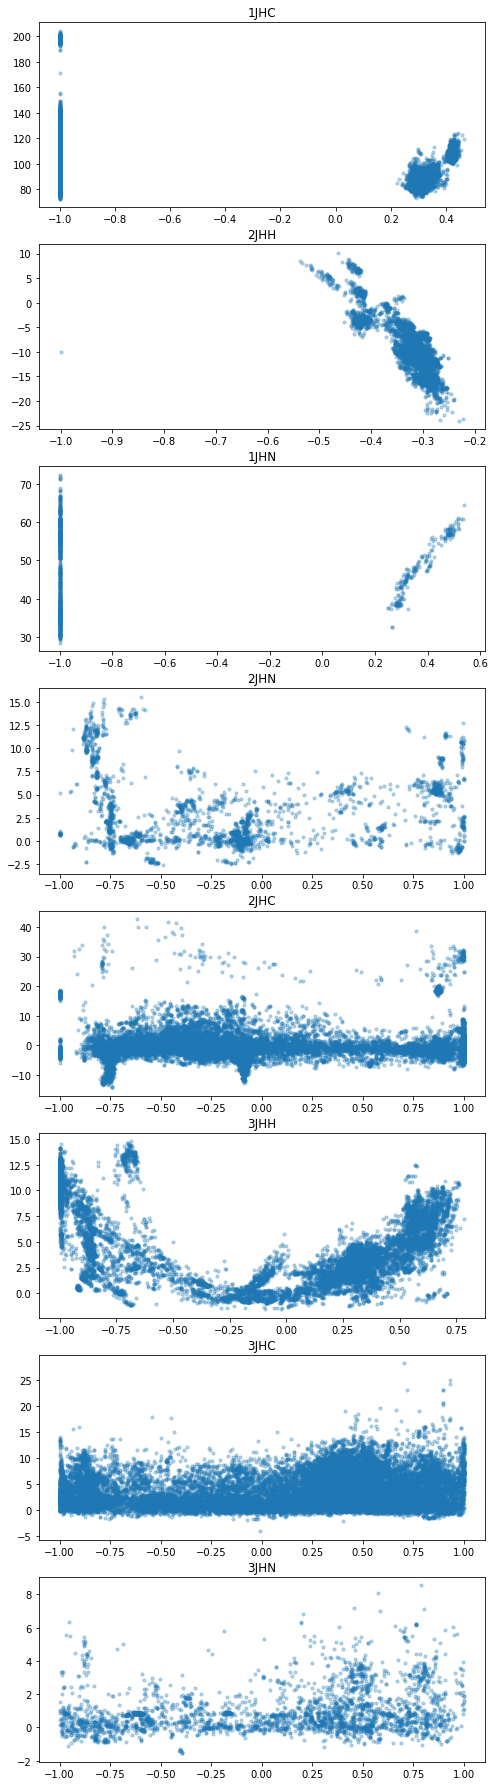

In [8]:
mol_types=df_train["type"].unique()
df_train_=df_train.iloc[:100000,:].copy()

fig, ax = plt.subplots(8, 1, figsize=(8, 32))
for i, mol_type in enumerate(mol_types):
    ax[i].scatter(df_train_.loc[df_train_['type'] ==mol_type]["cos_0_1"], df_train_.loc[df_train_['type'] == mol_type] ['scalar_coupling_constant'],s=10,alpha=0.3);
    ax[i].set_title(str(mol_type))

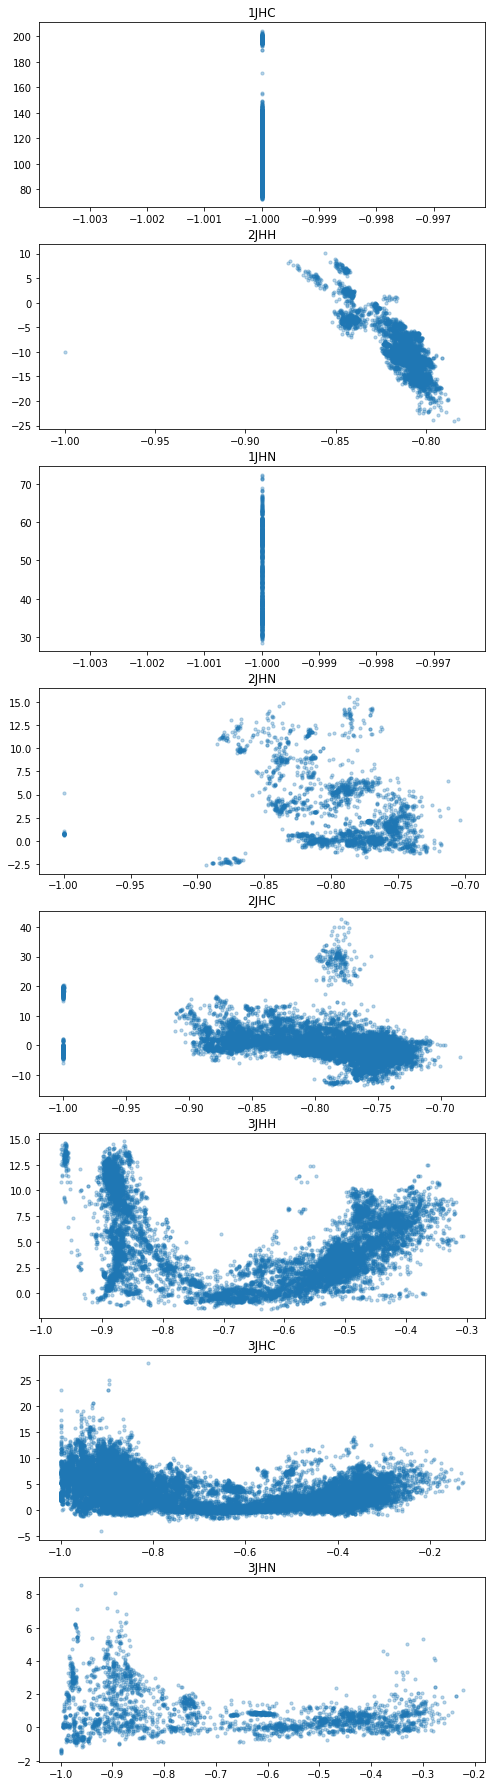

In [9]:
mol_types=df_train["type"].unique()
df_train_=df_train.iloc[:100000,:].copy()

fig, ax = plt.subplots(8, 1, figsize=(8, 32))
for i, mol_type in enumerate(mol_types):
    ax[i].scatter(df_train_.loc[df_train_['type'] ==mol_type]["cos_0"], df_train_.loc[df_train_['type'] == mol_type] ['scalar_coupling_constant'],s=10,alpha=0.3);
    ax[i].set_title(str(mol_type))

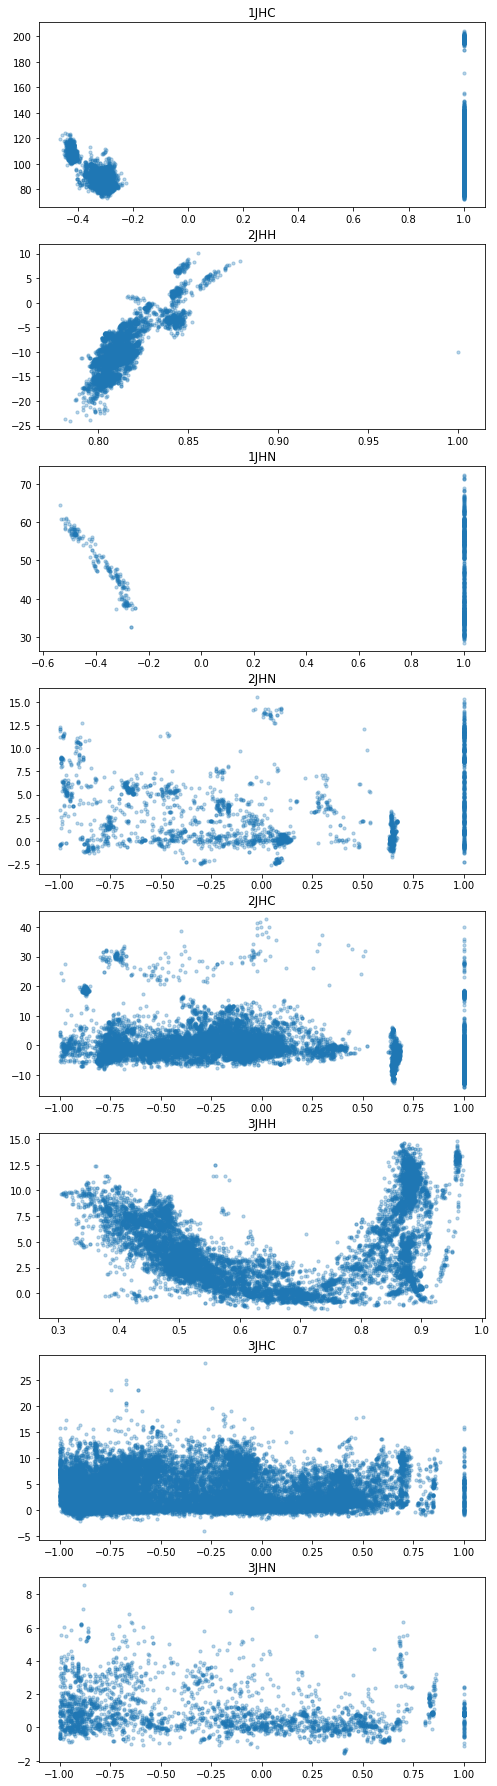

In [10]:
mol_types=df_train["type"].unique()
df_train_=df_train.iloc[:100000,:].copy()

fig, ax = plt.subplots(8, 1, figsize=(8, 32))
for i, mol_type in enumerate(mol_types):
    ax[i].scatter(df_train_.loc[df_train_['type'] ==mol_type]["cos_1"], df_train_.loc[df_train_['type'] == mol_type] ['scalar_coupling_constant'],s=10,alpha=0.3);
    ax[i].set_title(str(mol_type))